In [2]:
options(repr.plot.width  = 15, repr.plot.height = 10)

# Libraries

In [3]:
#install.packages("gbm")
#install.packages("xgboost")

In [4]:
# Helper packages
library(dplyr)    # for general data wrangling needs

# Modeling packages
library(caret)
library(gbm)      # for original implementation of regular and stochastic GBMs
library(h2o)      # for a java-based implementation of GBM variants
library(xgboost)  # for fitting extreme gradient boosting
library(rpart)

library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2

Loaded gbm 2.1.8


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



Attac

# Load data

In [5]:
ames <- AmesHousing::make_ames()

response <- "Sale_Price"
predictors <- setdiff(colnames(ames), response)

# Split Dataset

In [6]:
set.seed(123)
index_train <- createDataPartition(ames$Sale_Price, p = 0.8, 
                               list = FALSE, )
index_train  <- as.vector(index_train)

house_train <- ames[index_train, ]
house_test  <- ames[-index_train, ]

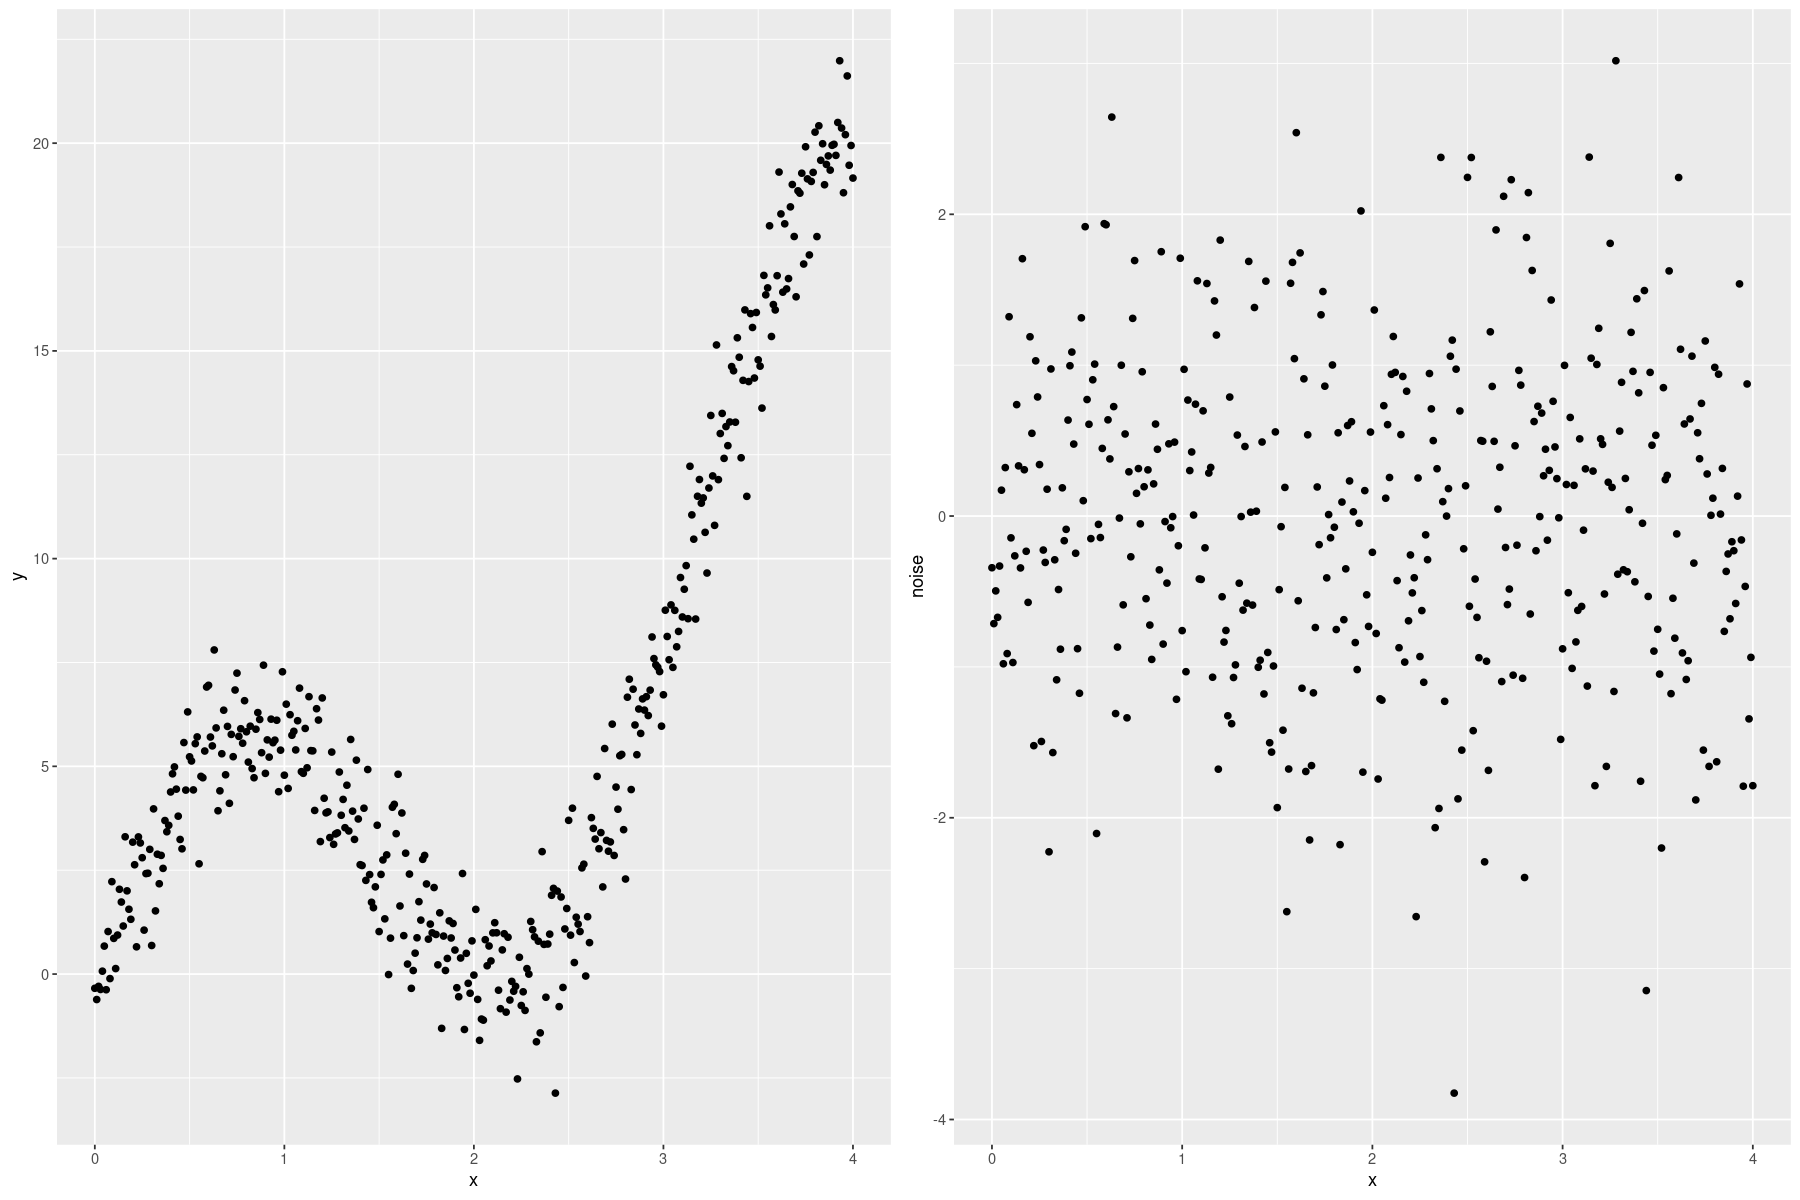

In [19]:
x <- seq(0, 4, 0.01)
noise <- rnorm(length(x))
data_fake <- data.frame(
    x = x,
    y = x**2 + 5*sin(x*2) + noise,
    noise = noise
)
p1 <- data_fake %>% ggplot(aes(x, y)) + geom_point()
p2 <- data_fake %>% ggplot(aes(x, noise)) + geom_point()
grid.arrange(p1,p2, nrow=1)

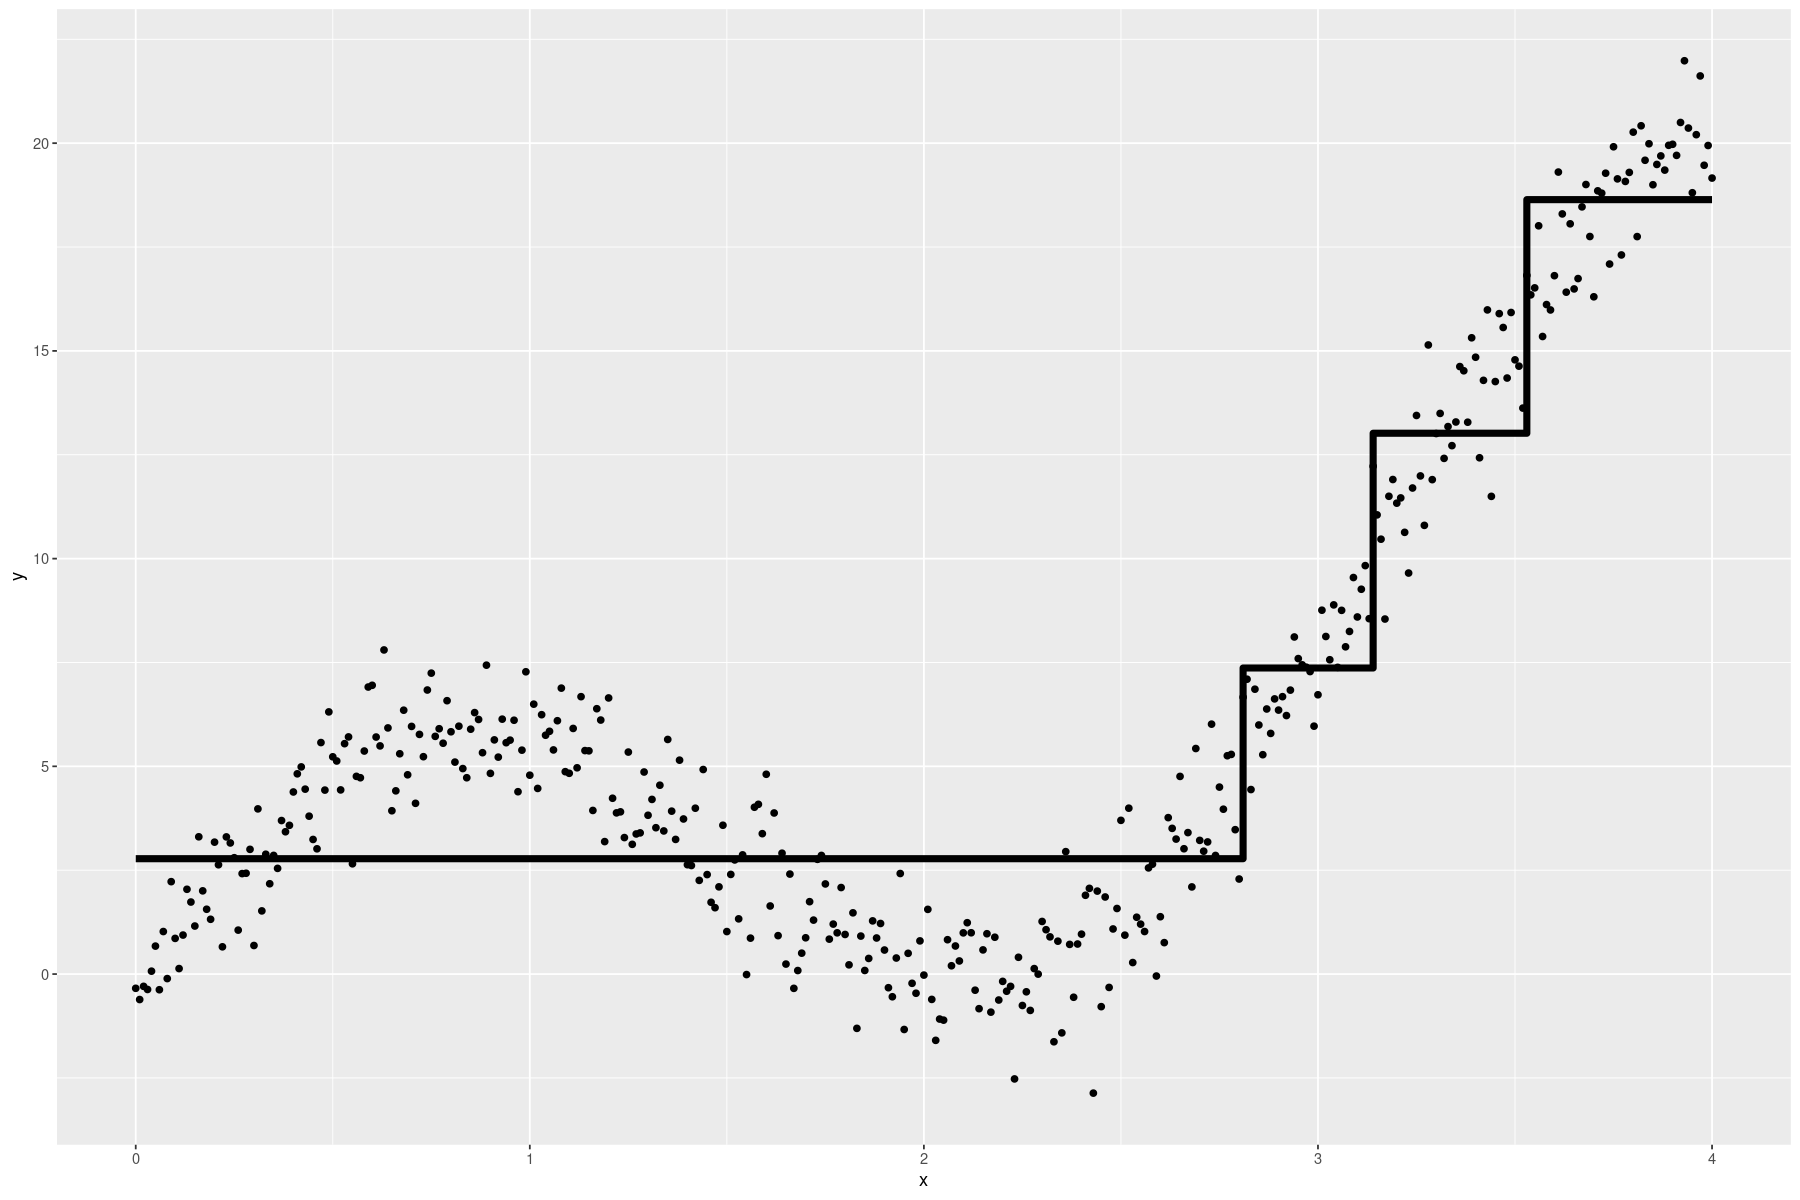

In [35]:
max_depth = 2
weak_learner1 = rpart(y ~ x, data = data_fake, maxdepth=max_depth)

data_fake$pred1 <- predict(weak_learner1, data_fake)
data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point() +
        geom_step(aes(x, pred1), size=2)

In [36]:
weak_learner2 = rpart((y-pred1) ~ x, data = data_fake, maxdepth=max_depth)
data_fake$pred2 <- predict(weak_learner2, data_fake)

unique(data_fake$pred1)
unique(data_fake$pred2)

[1]  2.776894  7.366858 13.017319 18.640329

[1] -1.2041042  2.2682600 -1.8793531  0.1400294

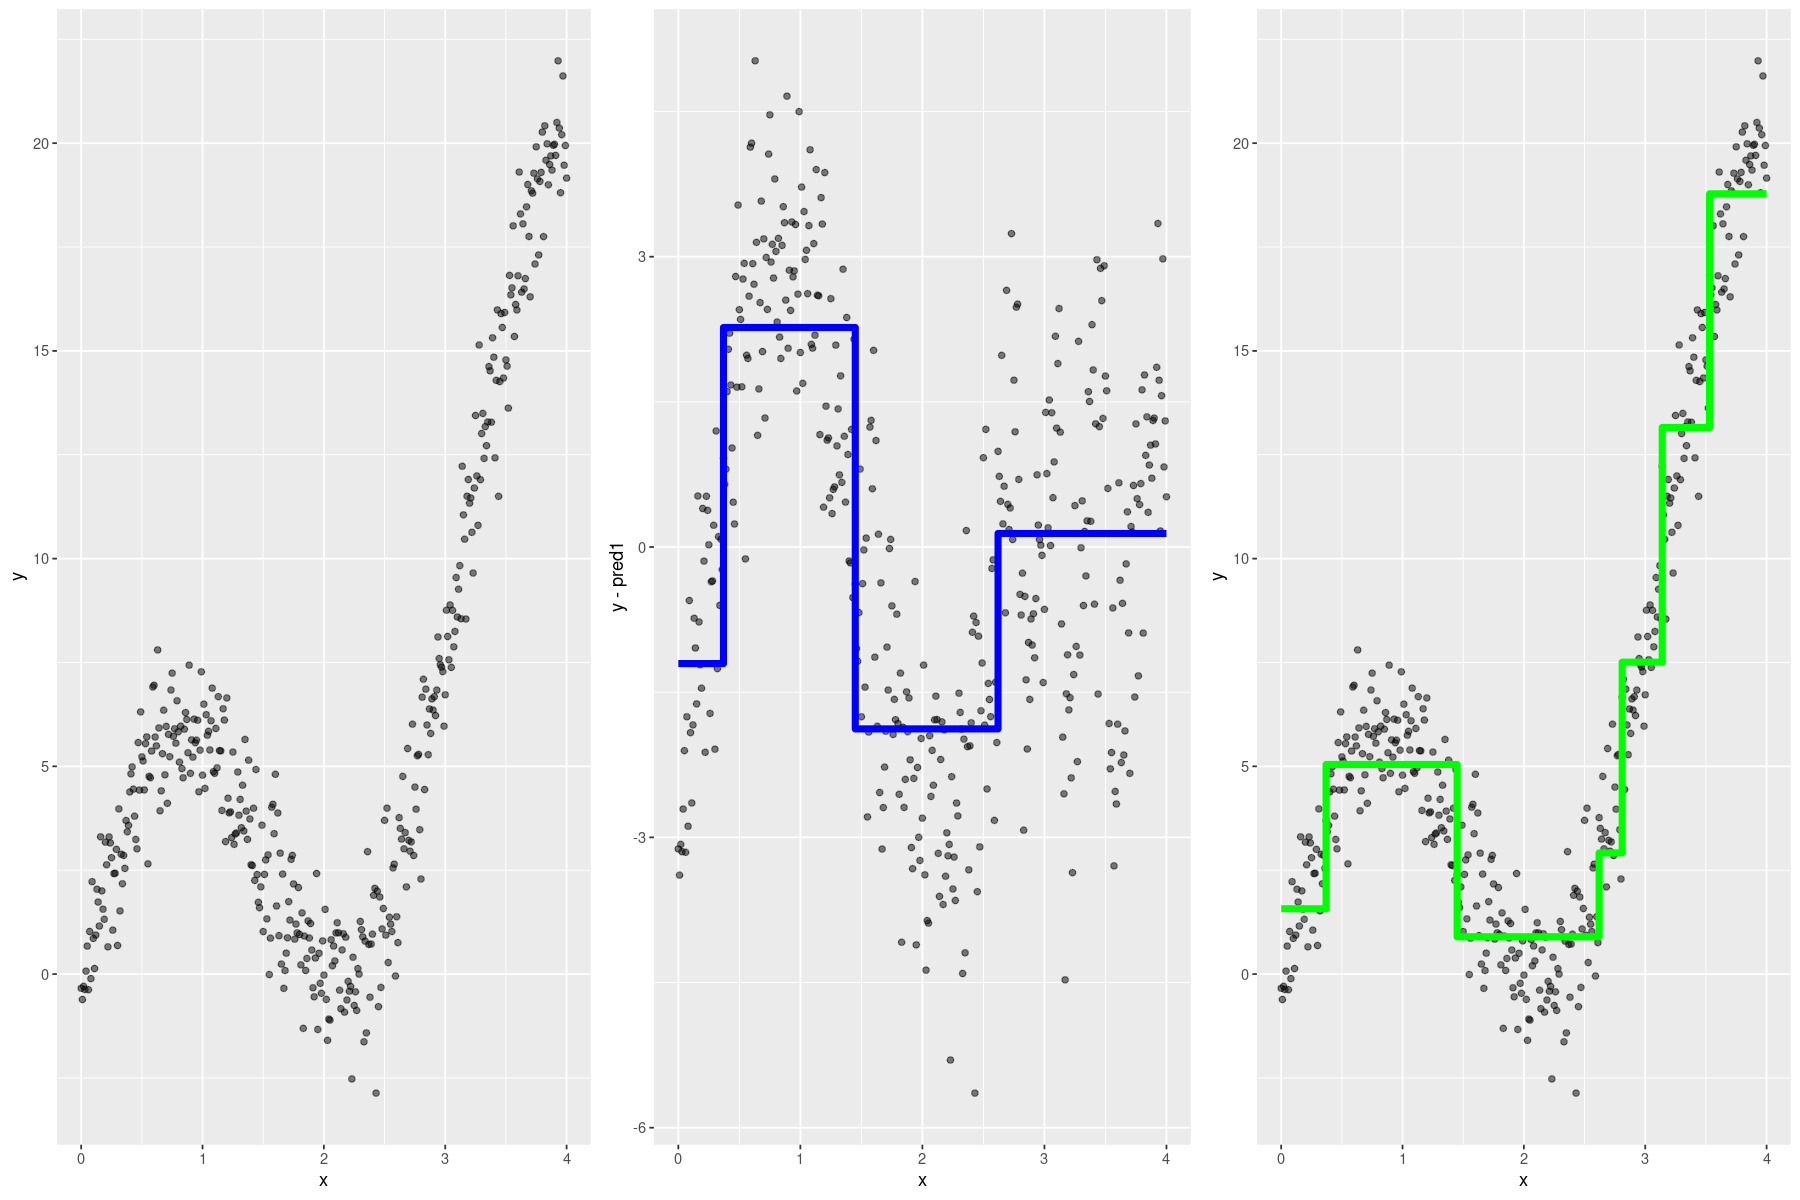

In [37]:
p1 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5)
        #geom_point(aes(x, (pred2)), color = 'blue') 
        
p2 <- data_fake %>% 
    ggplot(aes(x, y - pred1)) +
        geom_point(alpha=0.5) +
        #geom_point(aes(x, (pred + pred2)), color = 'green') + 
        #geom_point(aes(x, pred), color='red') +
        geom_step(aes(x, (pred2)), color = 'blue', size=2) 

p3 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, (pred1 + pred2)), color = 'green', size=2)
        #geom_point(aes(x, pred), color='red') +
        #geom_point(aes(x, (pred2)), color = 'blue') 


grid.arrange(p1, p2, p3, nrow = 1)

In [38]:
weak_learner3 = rpart((y - pred2 - pred1) ~ x, data = data_fake, maxdepth=max_depth)

data_fake$pred3 <- predict(weak_learner3, data_fake)

unique(data_fake$pred1)
unique(data_fake$pred2)
unique(data_fake$pred3)

[1]  2.776894  7.366858 13.017319 18.640329

[1] -1.2041042  2.2682600 -1.8793531  0.1400294

[1]  0.01904083 -1.00297517  1.17709833

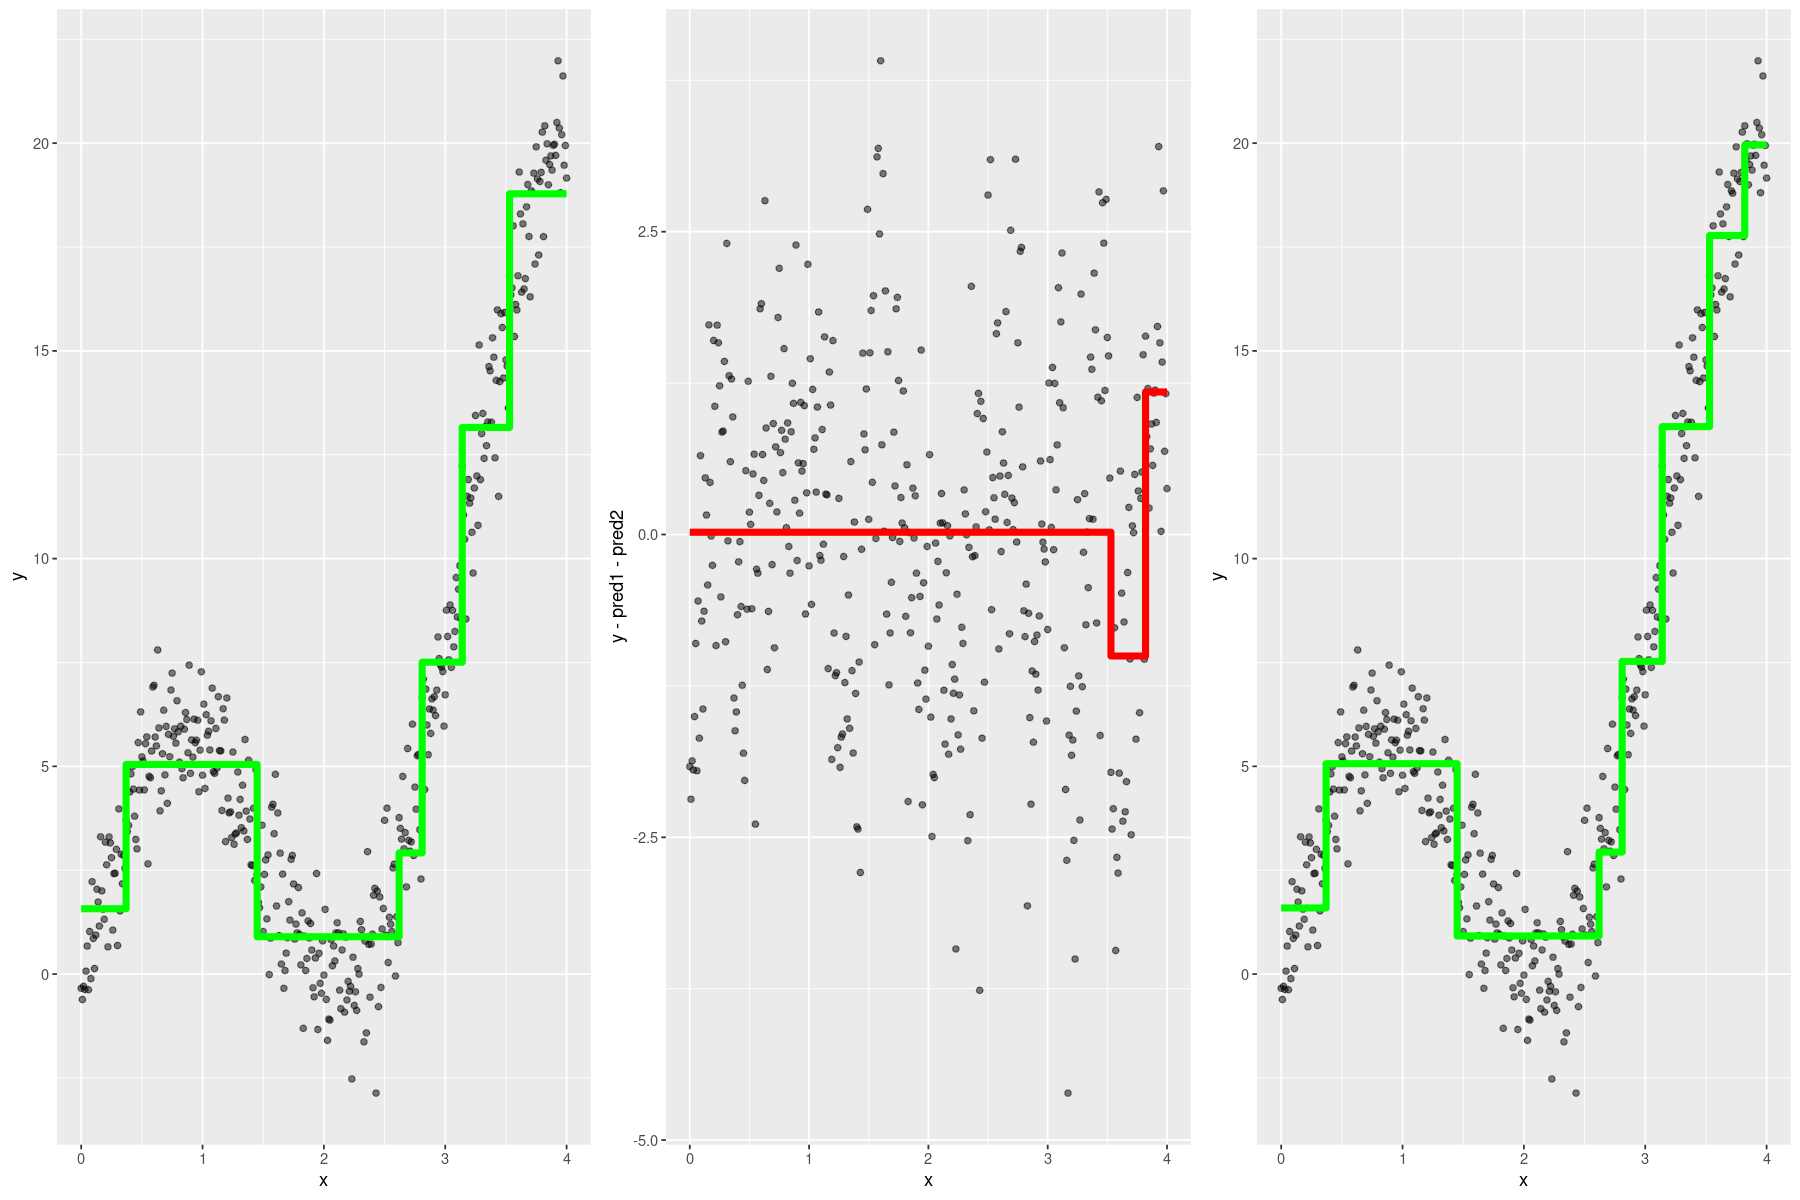

In [39]:
p1 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, (pred1 + pred2)), color = 'green', size=2)

p2 <- data_fake %>% 
    ggplot(aes(x, y - pred1 - pred2)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, pred3), color='red', size=2)
        #geom_point(aes(x, (pred2)), color = 'blue') 
        
p3 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, (pred1 + pred2 + pred3)), color = 'green', size=2)


grid.arrange(p1, p2, p3, nrow = 1)

In [40]:
weak_learner4 = rpart((y - pred3 - pred2 - pred1) ~ x, data = data_fake, maxdepth=max_depth)

data_fake$pred4 <- predict(weak_learner4, data_fake)

unique(data_fake$pred1)
unique(data_fake$pred2)
unique(data_fake$pred3)
unique(data_fake$pred4)

[1]  2.776894  7.366858 13.017319 18.640329

[1] -1.2041042  2.2682600 -1.8793531  0.1400294

[1]  0.01904083 -1.00297517  1.17709833

[1] -1.6299040  0.2795106 -0.1498967

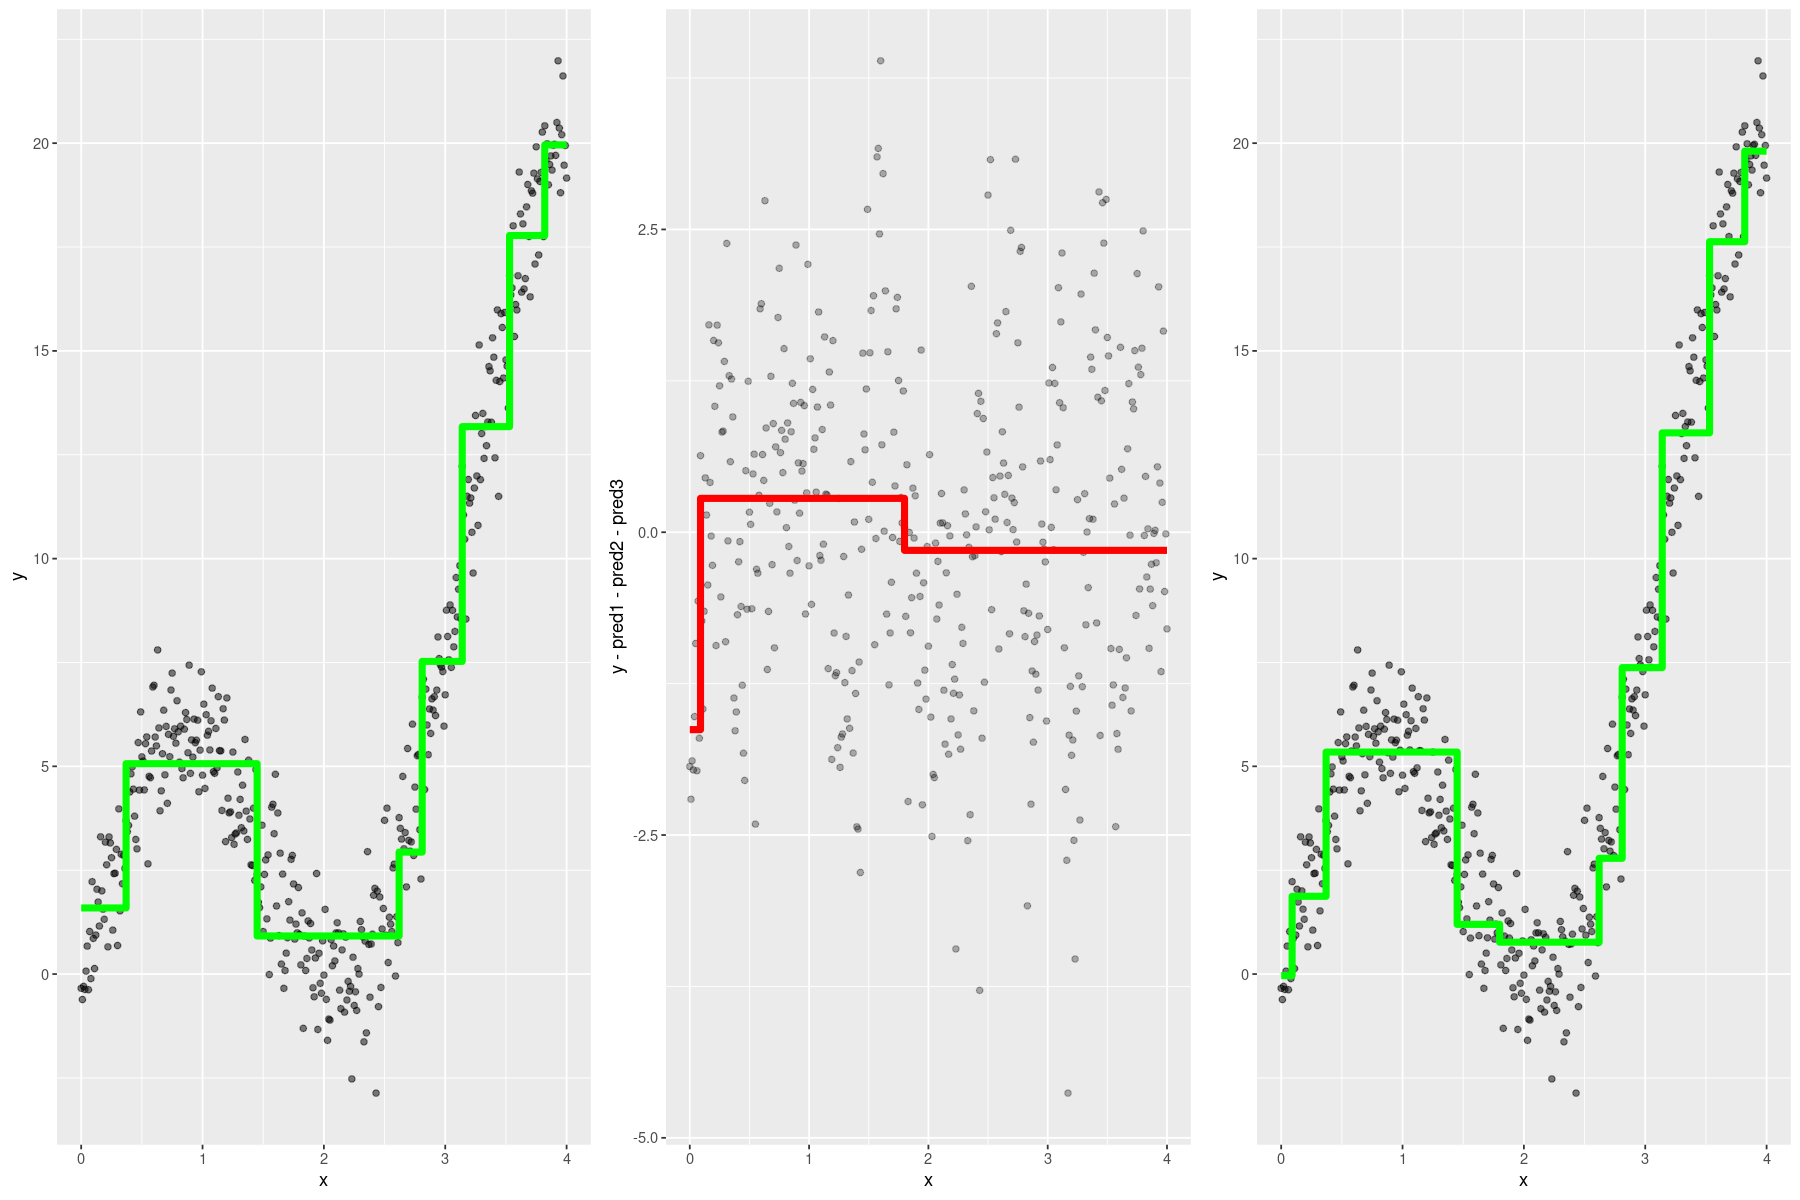

In [41]:
p1 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, (pred1 + pred2 + pred3)), color = 'green', size=2)

p2 <- data_fake %>% 
    ggplot(aes(x, y - pred1 - pred2 - pred3)) +
        geom_point(alpha=0.3) +
        geom_step(aes(x, pred4), color='red', size=2)
        #geom_point(aes(x, (pred2)), color = 'blue') 
        
p3 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, (pred1 + pred2 + pred3 + pred4)), color = 'green', size=2)


grid.arrange(p1, p2, p3, nrow = 1)

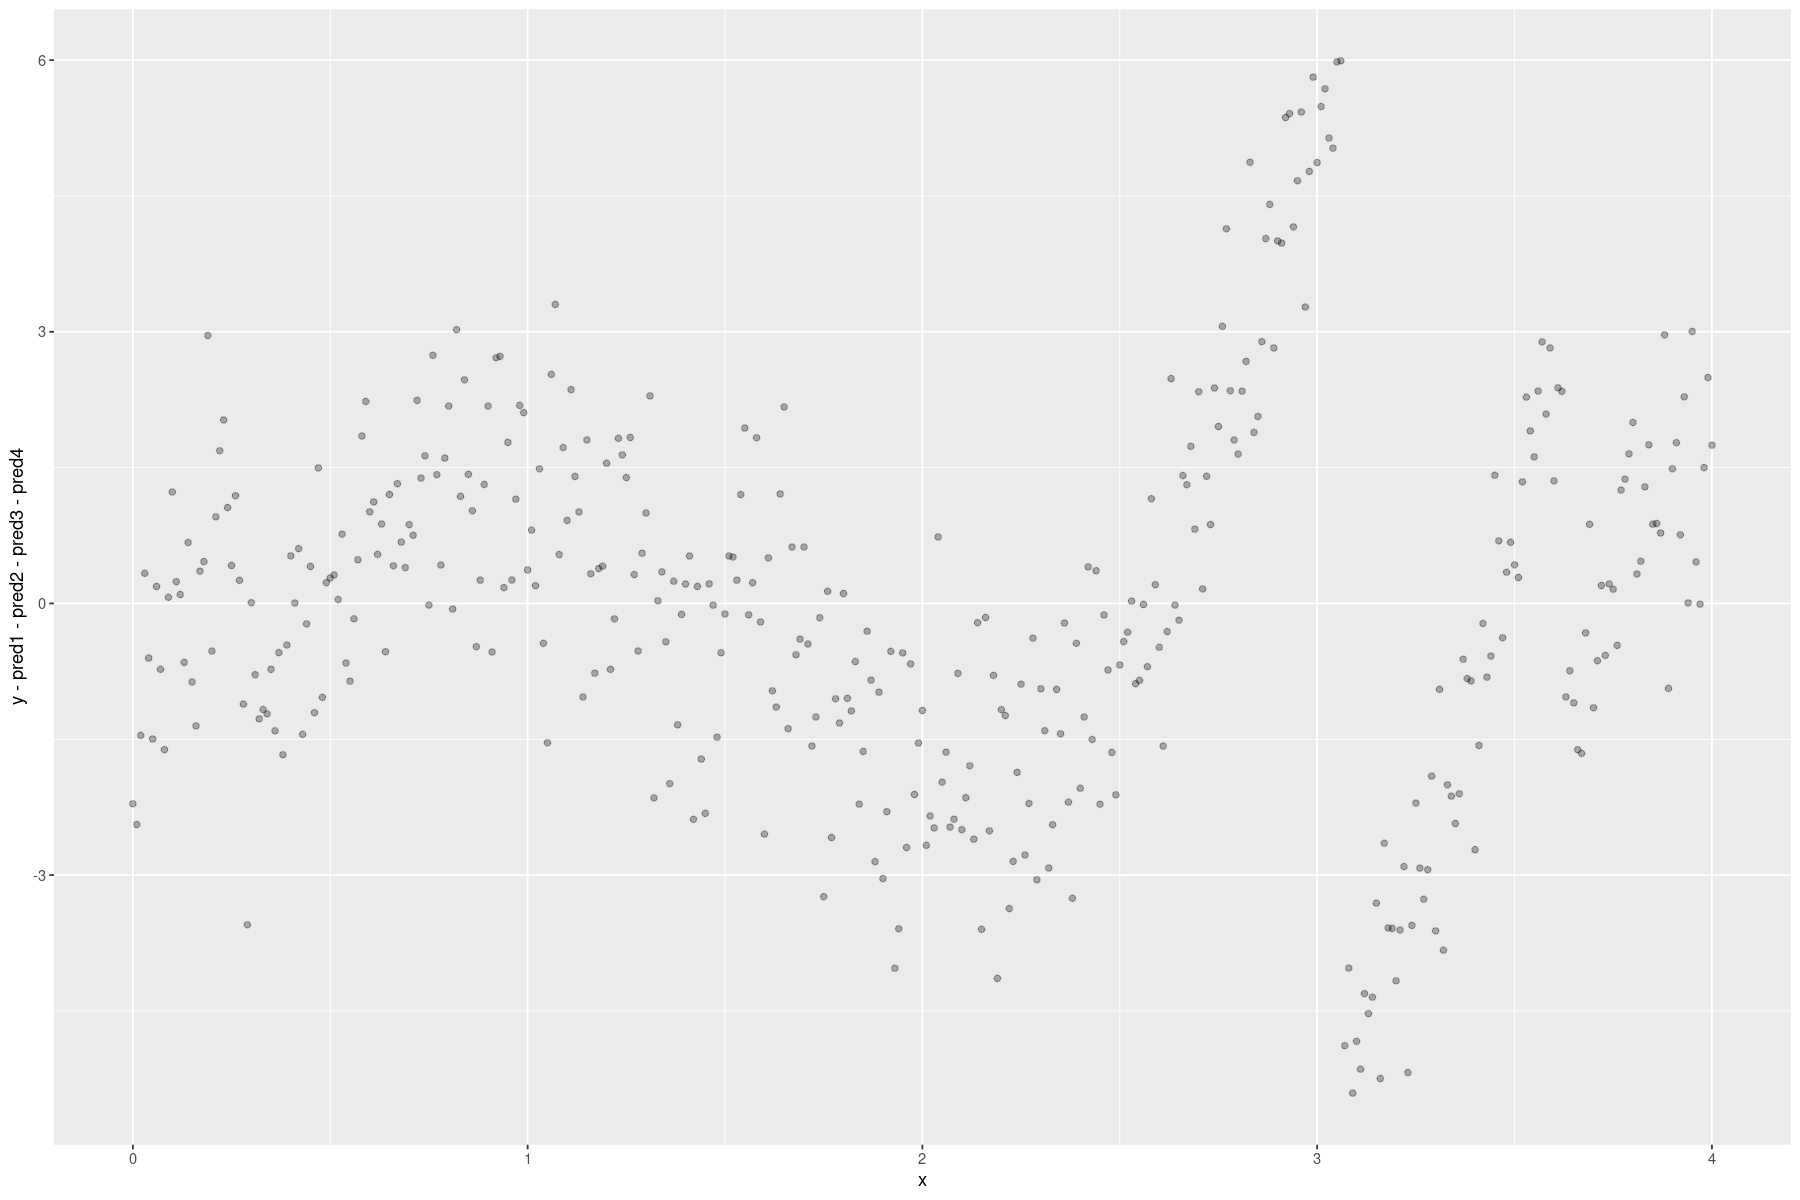

In [15]:
data_fake %>% 
    ggplot(aes(x, y - pred1 - pred2 - pred3 -pred4)) +
        geom_point(alpha=0.3)

# Modeling
## Basic GBM

**Hyperparameters**
LA version simple de GBM tiene 2 tipos de hiper-parametros:
   * boosting
   * especificos de los arboles

**Hiper-parametros de Boosting**
* **Numero de arboles**: el numero total de arboles en la secuencia. A diferencia de Bagging y RF donde el numero de arboles raramente puede generar overfitting, en boosting el hecho de la dependencia con el error del arbol anterior lo hace propenso a hacer overfittig, en general este numero puede variar en dependencia de los otros hiper-pármetros.
* **Learning rate (shrinkage)**: determina la contribucion de cada arbon en el resultado final  y controla la velocidad con la que el algoritmo desciende. Este valor va entre $[0, 1]$ y valores tipicos van entre $0.001$ - $0.3$. Valores mas pequeños hacen mas robusto a caracteristicas especificas de cada arbol, permitiendo generalizaar bien. Sin embargo valores pequeños pueden llevar a no encontrar el punto optimo y quedar en un minimo local. Generalmente valores mas pequeños logran un performance mejor pero requiere de un numero mayor de arboles en la secuencia.

**Hiper-parametros propios de cada arbol**

* **Profundidad del arbol**: Controla el la profundida maxima de cada arbol. Los valores tipicos van entre 3-8 pero no es raro ver arboles con profundad 1. Valore bajos son computacionalmente eficiente pero requiren de mas arboles en toral. Sin embargo valores mas grandes permiten capturar interacciones entre las features pero lo hace propenso a hacer overfitting.
* **Numero minimo de observacioens en un nodo**: controla la complejidad del arbon. Dado que los arboles tienden a ser poco profundos tiende a tener poco efecto. Valore tipicos van entre 5-15. Valores grandes pueden ayudar a prevenir relaciones muy especificas entre variables (overfitting) pero para los casos de dataset desbalanceados valores pequeños pueden ayudar a detectar los casos de la clase minoritaria.

In [16]:
# run a basic GBM model
set.seed(123)  # for reproducibility
ames_gbm1 <- gbm(
  formula = Sale_Price ~ .,
  data = house_train,
  distribution = "gaussian",  # SSE loss function
  n.trees = 5000,  # default = 100
  shrinkage = 0.1,  # default = 0.1
  interaction.depth = 3,
  n.minobsinnode = 10,
  cv.folds = 10
)

# find index for number trees with minimum CV error
best <- which.min(ames_gbm1$cv.error)

# get MSE and compute RMSE
sqrt(ames_gbm1$cv.error[best])
## [1] 23240.38

ERROR: Error in serialize(data, node$con): error writing to connection


In [ ]:
# plot error curve
gbm.perf(ames_gbm1, method = "cv")